In [1]:
import itertools
from functools import partial

import numpy as np
from tqdm import tqdm

import jax
jax.config.update("jax_default_matmul_precision", "highest")
import jax.numpy as jnp
from jax_tqdm import scan_tqdm

from special_unitary import LALG_SU_N, proj_SU3, unitary_violation, special_unitary_grad

from gauge_field_utils import wilson_action, accurate_wilson_hamiltonian_error, smear_HYP, smear_stout, wilson_loops_range, luscher_weisz_action
from integrators import int_LF2, int_MN2_omelyan, int_MN4_takaishi_forcrand

%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
def HMC(action_fn, beta, integrator, tau_md=1.0, steps_md=10, unitary_violation_tol=5e-6):

    action_grad = special_unitary_grad(lambda x: action_fn(x, beta))
    
    def step_fn(links, random_key, skip_metropolis=False):
        key1, key2 = jax.random.split(random_key, 2)
        Nc = links.shape[-1]

        p0 = jax.random.normal(key1, shape=(*links.shape[:-2], Nc*Nc-1))

        links_next, p_final = integrator(links, p0, action_grad, tau_md, steps_md)
        links_next = jax.lax.cond(
            unitary_violation_tol is not None,
            lambda: jax.lax.cond(
                unitary_violation(links_next, "mean") > unitary_violation_tol,
                proj_SU3,
                lambda x: x,
                links_next
            ),
            lambda: links_next
        )

        delta_hamiltonian = accurate_wilson_hamiltonian_error(links, p0, links_next, p_final, beta)
        p_acc = jnp.minimum(1, jnp.exp(-delta_hamiltonian))
        
        return jax.lax.cond(
            skip_metropolis,
            lambda: links_next,
            lambda: jax.lax.cond(
                jax.random.uniform(key2) < p_acc,
                lambda: links_next,
                lambda: links
            )
        ), (delta_hamiltonian, p_acc)
    
    return jax.jit(step_fn)

In [3]:
L = (12, 12, 12, 12)

random_key, key1, key2 = jax.random.split(jax.random.key(0), num=3)
gauge_links = LALG_SU_N(jax.random.normal(key1, shape=(*L, 4, 8), dtype=jnp.float32))
# gauge_links = LALG_SU_N(jnp.load("warmed_32_16x3_beta_6p0.npy"))

In [4]:
stepper_fn = HMC(
    action_fn=wilson_action,
    beta=5.7,
    integrator=int_MN2_omelyan,
    tau_md=1.0,
    steps_md=10,
    unitary_violation_tol=6e-5,
)

In [13]:
force_fn = special_unitary_grad(lambda x: wilson_action(x, 6.0))

In [15]:
test_res = force_fn(gauge_links)

In [17]:
test_res

Array([[[[[[nan, nan, nan, ..., nan, nan, nan],
           [nan, nan, nan, ..., nan, nan, nan],
           [nan, nan, nan, ..., nan, nan, nan],
           [nan, nan, nan, ..., nan, nan, nan]],

          [[nan, nan, nan, ..., nan, nan, nan],
           [nan, nan, nan, ..., nan, nan, nan],
           [nan, nan, nan, ..., nan, nan, nan],
           [nan, nan, nan, ..., nan, nan, nan]],

          [[nan, nan, nan, ..., nan, nan, nan],
           [nan, nan, nan, ..., nan, nan, nan],
           [nan, nan, nan, ..., nan, nan, nan],
           [nan, nan, nan, ..., nan, nan, nan]],

          ...,

          [[nan, nan, nan, ..., nan, nan, nan],
           [nan, nan, nan, ..., nan, nan, nan],
           [nan, nan, nan, ..., nan, nan, nan],
           [nan, nan, nan, ..., nan, nan, nan]],

          [[nan, nan, nan, ..., nan, nan, nan],
           [nan, nan, nan, ..., nan, nan, nan],
           [nan, nan, nan, ..., nan, nan, nan],
           [nan, nan, nan, ..., nan, nan, nan]],

          [[na

In [8]:
configs = []
next_links = gauge_links
for i in (bar := tqdm(range(2000))):
    next_links, aux = stepper_fn(next_links, jax.random.key(int(10000*np.random.rand())))
    bar.set_postfix({"dH": aux[0]})
    configs.append(np.array(next_links))
configs = np.stack(configs)

  0%|          | 7/2000 [00:01<08:17,  4.01it/s, dH=nan]


KeyboardInterrupt: 

In [57]:
smeared_configs = np.stack([np.array(smear_stout(c, n=5, rho=0.2, temporal=False)) for c in tqdm(configs)])

100%|██████████| 905/905 [02:19<00:00,  6.51it/s]


In [83]:
wilson_loops = np.stack([wilson_loops_range(c, 12, 5) for c in tqdm(smeared_configs)])

100%|██████████| 905/905 [00:25<00:00, 35.24it/s]


In [84]:
@partial(jax.jit, static_argnums=(1,))
def jackknife_stats(data, statistic):
    N = len(data)

    jack_estimates = jax.vmap(lambda x, i: statistic(jnp.delete(x, i, axis=0, assume_unique_indices=True)), in_axes=[None, 0])(data, jnp.arange(N))

    estimate = jnp.mean(jack_estimates, axis=0)
    # bias = (N - 1) * (estimate - statistic(data))
    stderr = jnp.sqrt((N - 1) * jnp.var(jack_estimates, axis=0, ddof=1))

    return estimate, stderr

In [ ]:
mean_wilson_loops, err_wilson_loops = jackknife_stats(wilson_loops[60:].real, lambda x: jnp.mean(x, axis=0))

print(f"Mean plaquette: {mean_wilson_loops[0, 0]:.6f} ({err_wilson_loops[0, 0]:.6f})")

Mean plaquette: 0.934179 (0.000192)


In [171]:
@jax.jit
def effective_potential(W1, W2, dW1, dW2):
    energy_fn = lambda x: jnp.log(x[0] / x[1])
    stderr_fn = lambda x, dx: jnp.sqrt(jnp.square(jax.grad(energy_fn)(x) * dx).sum())

    X = jnp.stack([W1, W2], axis=1)
    dX = jnp.stack([dW1, dW2], axis=1)

    V = jax.vmap(energy_fn, in_axes=(0,))(X)
    dV = jax.vmap(stderr_fn, in_axes=(0, 0))(X, dX)

    return V, dV

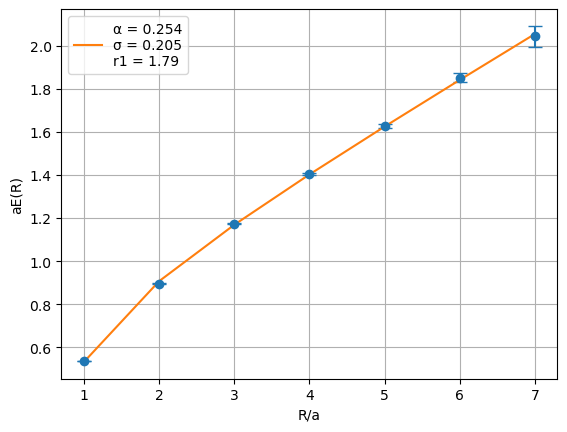

In [195]:
R_range = (0, -5)
T_level = 0

V, dV = effective_potential(mean_wilson_loops[R_range[0]:R_range[1], T_level], mean_wilson_loops[R_range[0]:R_range[1], T_level+1],
                    err_wilson_loops[R_range[0]:R_range[1], T_level], err_wilson_loops[R_range[0]:R_range[1], T_level+1])
R = (jnp.arange(len(V))+1).astype(jnp.float32)

V0_latt, alpha_latt, sigma_latt = jax.scipy.optimize.minimize(lambda x: jnp.square(x[0] - 4*x[1]/(3*R) + x[2]*R - V).mean(), x0=jnp.array([0.1, 0.1, 0.1]), method="BFGS").x
V_fit = V0_latt - 4*alpha_latt/(3*R) + sigma_latt*R
sommer_r1 = jnp.sqrt((1.00 - 4*alpha_latt/3) / sigma_latt)

plt.errorbar(R, V, dV, fmt='o', capsize=5)
plt.plot(R, V_fit, label=f"α = {alpha_latt:.3g}\nσ = {sigma_latt:.3g}\nr1 = {sommer_r1:.3g}")

plt.xlabel("R/a")
plt.ylabel("aE(R)")
plt.legend()
plt.grid()
plt.show()

In [196]:
0.36 / (np.sqrt(sigma_latt) / 440 * 1000 / 5.068)

np.float32(1.7714148)

In [197]:
np.sqrt(sigma_latt) / 440 * 1000 / 5.068

np.float32(0.2032274)